In [114]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from enum import IntEnum
from collections import Counter
import numpy as np
from enum import Enum
import math

In [1]:
dataset_path = "../datasets/OCDetect/"
export_folder_path = "../datasets/OCDetect/preprocessed/OCDetect_Export/"


## 1. Amount of files filtered out completely

In [6]:
file_dict = {}
for entry in os.scandir(dataset_path):
    if entry.is_dir() and entry.name.startswith('OCDetect_'):
        folder_name = entry.name
        key = folder_name.replace('OCDetect_', '')
        if '_' in key:
            main_key = key.split('_')[0]
            target_dir = os.path.join(dataset_path, folder_name)
            for file_entry in os.scandir(target_dir):
                if file_entry.is_file() and file_entry.name.endswith('.csv'):
                    filename = os.path.splitext(file_entry.name)[0]
                    if main_key not in file_dict:
                        file_dict[main_key] = []
                    file_dict[main_key].append(filename)
        else:
            target_dir = os.path.join(dataset_path, folder_name)
            for file_entry in os.scandir(target_dir):
                if file_entry.is_file() and file_entry.name.endswith('.csv'):
                    filename = os.path.splitext(file_entry.name)[0]
                    if key not in file_dict:
                        file_dict[key] = []
                    file_dict[key].append(filename)

In [7]:
file_deletion_stats = {}

for file_name in os.listdir(export_folder_path):
    if file_name.endswith('.csv') and file_name.startswith('OCDetect_'):
        user_id = file_name.split('OCDetect_')[1].split('_')[0]

        hash_value = file_name.split('_')[-1].split('.')[0]
        if user_id not in file_deletion_stats:
            file_deletion_stats[user_id] = (len(file_dict[user_id]), 0)
                                            
        count, not_found = file_deletion_stats[user_id]

        count, not_found = file_deletion_stats[user_id]
        file_deletion_stats[user_id] = (count, not_found + (hash_value not in file_deletion_stats[user_id]))

In [8]:
file_deletion_stats = dict(sorted(file_deletion_stats.items()))
for key, value in file_deletion_stats.items():
    total_files = value[0]
    deleted_files = value[1]
    kept_files_percentage = (total_files - deleted_files) / total_files * 100

    print(f"Statistic for User {key}:")
    print(f"- Amount of files before preprocessing: {total_files}")
    print(f"- Amount of deleted files: {deleted_files}")
    print(f"- Percentage of kept files: {kept_files_percentage:.2f}%\n")

# Calculate overall statistics
overall_total_files = sum(value[0] for value in file_deletion_stats.values())
overall_deleted_files = sum(value[1] for value in file_deletion_stats.values())
overall_kept_files_percentage = (overall_total_files - overall_deleted_files) / overall_total_files * 100
overall_deleted_files_percentage = overall_deleted_files / overall_total_files * 100

print("-----------------------------------------------------------------------------")
print("Overall statistic:")
print(f"- Amount of users: {len(file_deletion_stats.keys())}")
print(f"- Amount of all files before preprocessing: {overall_total_files}")
print(f"- Amount of deleted files: {overall_deleted_files}")
print(f"- Overall percentage of kept files: {overall_kept_files_percentage:.2f}%")
print(f"- Overall percentage of deleted files: {overall_deleted_files_percentage:.2f}%")
print("-----------------------------------------------------------------------------")


Statistic for User 01:
- Amount of files before preprocessing: 81
- Amount of deleted files: 42
- Percentage of kept files: 48.15%

Statistic for User 02:
- Amount of files before preprocessing: 54
- Amount of deleted files: 35
- Percentage of kept files: 35.19%

Statistic for User 03:
- Amount of files before preprocessing: 48
- Amount of deleted files: 31
- Percentage of kept files: 35.42%

Statistic for User 04:
- Amount of files before preprocessing: 51
- Amount of deleted files: 42
- Percentage of kept files: 17.65%

Statistic for User 05:
- Amount of files before preprocessing: 71
- Amount of deleted files: 47
- Percentage of kept files: 33.80%

Statistic for User 07:
- Amount of files before preprocessing: 53
- Amount of deleted files: 21
- Percentage of kept files: 60.38%

Statistic for User 09:
- Amount of files before preprocessing: 543
- Amount of deleted files: 31
- Percentage of kept files: 94.29%

Statistic for User 10:
- Amount of files before preprocessing: 55
- Amount 

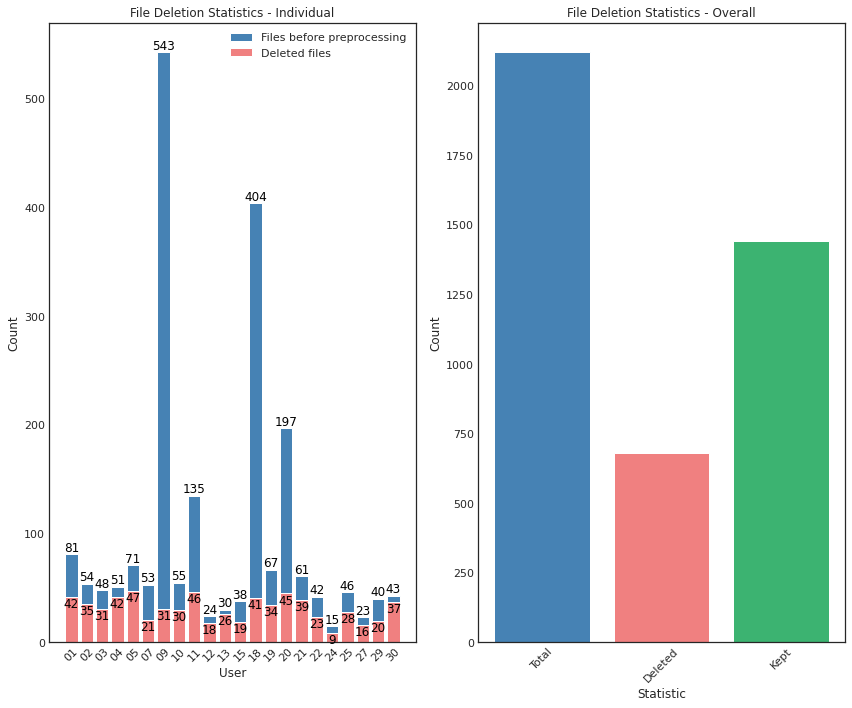

In [26]:

# Set plot aesthetics
plt.style.use('seaborn-white')

file_deletion_stats = dict(sorted(file_deletion_stats.items()))
keys = file_deletion_stats.keys()
total_files = [value[0] for value in file_deletion_stats.values()]
deleted_files = [value[1] for value in file_deletion_stats.values()]
kept_files_percentage = [(total - deleted) / total * 100 for total, deleted in zip(total_files, deleted_files)]

# Create subplots for individual statistics and overall statistics
fig, axes = plt.subplots(1, 2, figsize=(12, 10))


# Plot individual statistics
axes[0].bar(keys, total_files, label='Files before preprocessing', color='steelblue')
axes[0].bar(keys, deleted_files, label='Deleted files', color='lightcoral')
axes[0].set_xlabel('User')
axes[0].set_ylabel('Count')
axes[0].set_title('File Deletion Statistics - Individual')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)
axes[0].yaxis.grid(False)  # Remove the grid

# Add labels with absolute numbers on top and below the bars
for x, y_total, y_deleted in zip(keys, total_files, deleted_files):
    axes[0].text(x, y_total, str(y_total), ha='center', va='bottom', color='black')
    axes[0].text(x, y_deleted - 0.001 * max(total_files), str(y_deleted), ha='center', va='top', color='black')

# Plot overall statistics
overall_labels = ['Total', 'Deleted', 'Kept']
overall_values = [overall_total_files, overall_deleted_files, overall_total_files - overall_deleted_files]
axes[1].bar(overall_labels, overall_values, color=['steelblue', 'lightcoral', 'mediumseagreen'])
axes[1].set_xlabel('Statistic')
axes[1].set_ylabel('Count')
axes[1].set_title('File Deletion Statistics - Overall')
axes[1].tick_params(axis='x', rotation=45)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

## 2. Regions marked as idle

In [31]:
data_dict = {}

for file_name in os.listdir(export_folder_path):
    if file_name.endswith('.csv') and file_name.startswith('OCDetect_'):
        user_id = file_name.split('OCDetect_')[1].split('_')[0]
        file_path = os.path.join(export_folder_path, file_name)
        df = pd.read_csv(file_path)
        
        if user_id in data_dict:
            data_dict[user_id].append(df)
        else:
            data_dict[user_id] = [df]

In [41]:

class IgnoreReason(IntEnum):
    DontIgnore = 0
    InitialHandWash = 1
    NoMovement = 2
    TooEarlyInRecording = 3
    RepetitionSame = 4
    RepetitionCompToRoutine = 5
    RepetitionRoutineToComp = 6

occurrences_dict = {}

for key, dataframes in data_dict.items():
    value_counts = Counter()
    total_values = 0
    for df in dataframes:
        if "ignore" in df.columns:
            ignore_values = df["ignore"].tolist()
            value_counts.update(ignore_values)
            total_values += len(ignore_values)
    occurrences_dict[key] = {IgnoreReason(value).name: count
                             for value, count in value_counts.items()}

# Sort occurrences_dict by key
occurrences_dict = dict(sorted(occurrences_dict.items()))

# Print ignore reasons statistics
print("Ignore Reasons Statistics")
print("------------------------------------------------")

# Print individual user statistics for ignore reasons
print("Individual user statistics for ignore reasons:")

print()

for key, value_counts in occurrences_dict.items():
    print(f"User {key}:")
    for value, count in value_counts.items():
        percentage = count / total_values * 100
        print(f"{value}: {count} ({percentage:.2f}%)")
    print()

# Calculate overall statistics
overall_counts = Counter()
overall_total_values = 0

for value_counts in occurrences_dict.values():
    overall_counts.update(value_counts)
    overall_total_values += sum(value_counts.values())
    
print("------------------------------------------------")

# Print overall statistics
print("Overall statistic:")
for value, count in overall_counts.items():
    percentage = count / overall_total_values * 100
    print(f"{value}: {count} ({percentage:.2f}%)")
print()

Ignore Reasons Statistics
------------------------------------------------
Individual user statistics for ignore reasons:

User 01:
DontIgnore: 29144121 (57.49%)
TooEarlyInRecording: 913 (0.00%)
NoMovement: 48594185 (95.86%)
RepetitionCompToRoutine: 20 (0.00%)
RepetitionSame: 29 (0.00%)
RepetitionRoutineToComp: 9 (0.00%)

User 02:
DontIgnore: 31283625 (61.71%)
NoMovement: 33901280 (66.87%)

User 03:
DontIgnore: 23684492 (46.72%)
NoMovement: 33366826 (65.82%)
TooEarlyInRecording: 224 (0.00%)
InitialHandWash: 1013 (0.00%)

User 04:
DontIgnore: 25035829 (49.38%)
NoMovement: 24414938 (48.16%)
TooEarlyInRecording: 53 (0.00%)
InitialHandWash: 942 (0.00%)

User 05:
DontIgnore: 40920762 (80.72%)
NoMovement: 26603244 (52.48%)
TooEarlyInRecording: 604 (0.00%)
InitialHandWash: 2351 (0.00%)

User 07:
DontIgnore: 9034663 (17.82%)
NoMovement: 9059045 (17.87%)
InitialHandWash: 2287 (0.00%)

User 09:
NoMovement: 47793231 (94.28%)
DontIgnore: 12798220 (25.25%)
TooEarlyInRecording: 478 (0.00%)
Repetitio

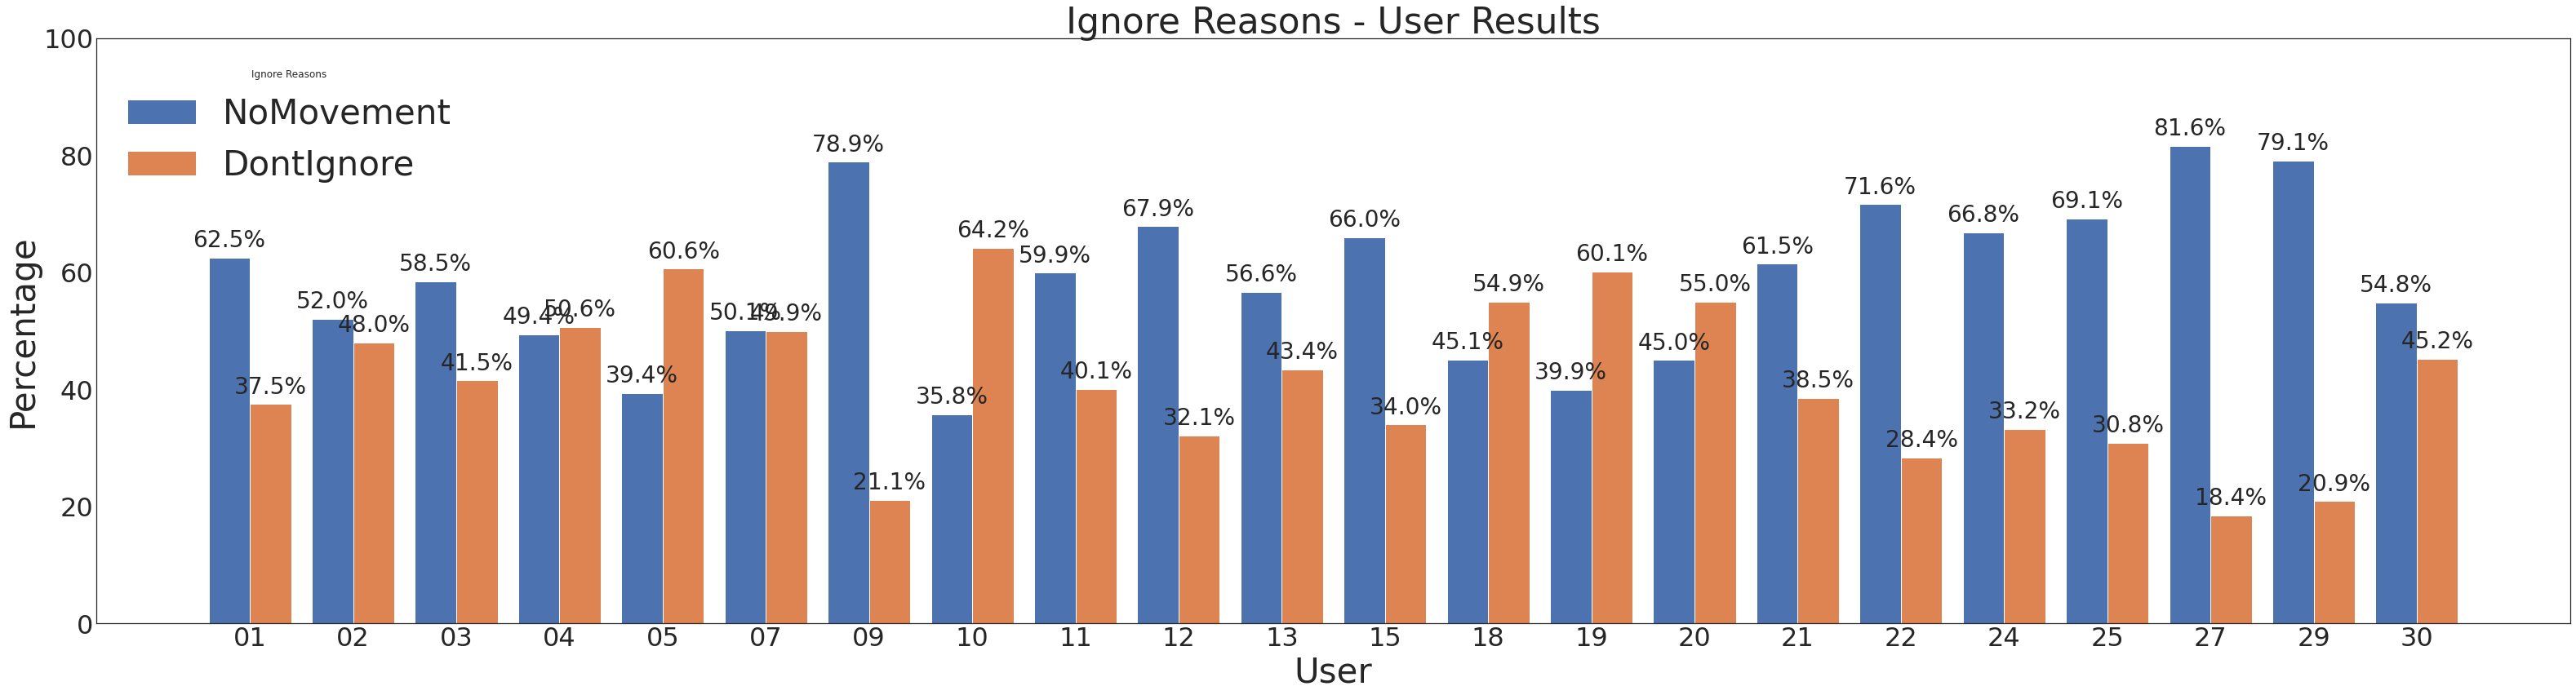

In [79]:
# Filtered values for visualization
filtered_values = ["NoMovement", "DontIgnore"]

# Prepare data for visualization
users = sorted(occurrences_dict.keys())
num_users = len(users)
bar_width = 0.4

# Calculate percentages for each user
percentages_dict = {}
for user in users:
    total = sum(occurrences_dict[user].values())
    percentages_dict[user] = {
        value: count / total * 100
        for value, count in occurrences_dict[user].items()
        if value in filtered_values
    }

# Create the bar plot
fig, ax = plt.subplots(figsize=(num_users * 2, 12))  # Adjust the figsize parameter

# Set the x positions for the bars
x = np.arange(num_users)

# Plot the bars for each value
for i, value in enumerate(filtered_values):
    percentages = [percentages_dict[user].get(value, 0) for user in users]
    ax.bar(x + i * bar_width, percentages, width=bar_width, label=value)
    # Add labels to the bars with increased font size
    for j, v in enumerate(percentages):
        ax.text(x[j] + i * bar_width, v + 1, f"{v:.1f}%", ha="center", va="bottom", fontsize=28)

# Set the x-axis ticks and labels with increased font size
ax.set_xticks(x + (len(filtered_values) - 1) * bar_width / 2)
ax.set_xticklabels(users, fontsize=32)

# Set the y-axis limits and label with increased font size
ax.set_ylim(0, 100)
ax.set_ylabel("Percentage", fontsize=42)
plt.yticks(fontsize=32)

# Set the x-axis title with increased font size
ax.set_xlabel("User", fontsize=42)

# Set the title and legend with increased font size
ax.set_title("Ignore Reasons - User Results", fontsize=44)
ax.legend(title="Ignore Reasons", fontsize=42)

# Show the plot
plt.tight_layout()
plt.show()

In [103]:
class HandWashingType(Enum):
    NoHandWash = 0
    Routine = 1
    Compulsive = 2

counts_dict = {}

# Calculate counts for each key (User) in data_dict
for key, dataframes in data_dict.items():
    counts = {
        HandWashingType.NoHandWash: 0,
        HandWashingType.Routine: 0,
        HandWashingType.Compulsive: 0
    }
    
    for df in dataframes:
        df_counts = df['relabeled'].value_counts()
        for value, count in df_counts.items():
            counts[HandWashingType(value)] += count
    
    counts_dict[key] = counts
    
# Print the counts and percentages for each key (User)
print("Relabeled Statistics")
print("------------------------------------------------")

for key, counts in counts_dict.items():
    total_count = sum(counts.values())
    
    # Check for ZeroDivisionError
    if total_count == 0:
        print(f"No counts available for User: {key}")
        print()
        continue
    
    print(f"User {key}:")
    for value, count in counts.items():
        percentage = (count / total_count) * 100
        print(f"Count of {value.name}: {count} ({percentage:.2f}%)")
    print()

# Calculate and print the overall statistics
overall_counts = {value: sum(counts[value] for counts in counts_dict.values()) for value in HandWashingType}
overall_total_count = sum(overall_counts.values())
print("------------------------------------------------")

print("Overall statistic:")
for value, count in overall_counts.items():
    percentage = (count / overall_total_count) * 100
    print(f"Count of {value.name}: {count} ({percentage:.2f}%)")
print()


Relabeled Statistics
------------------------------------------------
User 02:
Count of NoHandWash: 64797033 (99.40%)
Count of Routine: 382169 (0.59%)
Count of Compulsive: 5703 (0.01%)

User 07:
Count of NoHandWash: 18026010 (99.61%)
Count of Routine: 62381 (0.34%)
Count of Compulsive: 7604 (0.04%)

User 21:
Count of NoHandWash: 57351224 (99.64%)
Count of Routine: 199077 (0.35%)
Count of Compulsive: 6170 (0.01%)

User 05:
Count of NoHandWash: 66829451 (98.97%)
Count of Routine: 695609 (1.03%)
Count of Compulsive: 1901 (0.00%)

User 20:
Count of NoHandWash: 66629812 (98.96%)
Count of Routine: 23186 (0.03%)
Count of Compulsive: 678657 (1.01%)

User 19:
Count of NoHandWash: 61259488 (99.64%)
Count of Routine: 194252 (0.32%)
Count of Compulsive: 28939 (0.05%)

User 24:
Count of NoHandWash: 19491043 (99.79%)
Count of Routine: 24713 (0.13%)
Count of Compulsive: 15792 (0.08%)

User 25:
Count of NoHandWash: 72817977 (99.74%)
Count of Routine: 152278 (0.21%)
Count of Compulsive: 39921 (0.05%)



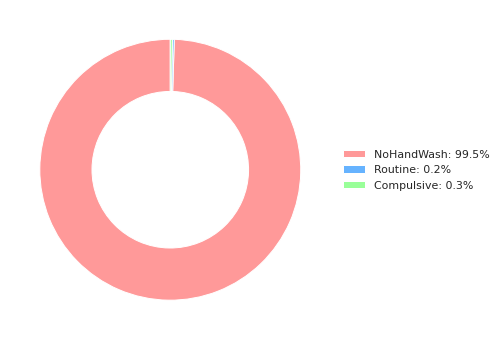

In [128]:
# Calculate the overall percentages
overall_percentages = [(count / overall_total_count) * 100 for count in overall_counts.values()]

# Create labels for the pie chart
labels = [value.name for value in HandWashingType]

# Set the colors for the pie chart
colors = ["#FF9999", "#66B3FF", "#99FF99"]

# Create the pie chart
plt.figure(figsize=(6, 6))
wedges, _ ,_ = plt.pie(overall_percentages, colors=colors, startangle=90, autopct="")

# Create legend with values
legend_labels = [f"{label}: {percentage:.1f}%" for label, percentage in zip(labels, overall_percentages)]
plt.legend(wedges, legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))

# Remove text from pie chart
plt.setp(wedges, width=0.4)  # Adjust the width of the wedges to remove text

# Show the legend
plt.axis('off')
plt.show()